<h1><center>Selecting Classifier Type</center></h1>

![title](images/Screen.png)

## Importing Libraries & Defining functions

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pickle
from datetime import datetime

# Preprocessing
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#Model Assestment
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report,precision_score, recall_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

#Models
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings('ignore')
#Add settings for SNS

import sys
sys.path.append('modules/')
from simp_pickle import load_pickle, save_pickle

## Loading Data

In [19]:
# Reviews Content
reviews = pd.read_csv('data/reviews_step_3.csv', index_col=0)
print(reviews.shape)
reviews.head(3)

(9596, 30)


,ship_link,links,user_date,user_link,user_contributions,user_helpful_votes,stars,title,content,meta,...,word_count,stars_grouped,vader_title_compound,vader_title_neg,vader_title_neu,vader_title_pos,vader_content_compound,vader_content_neg,vader_content_neu,vader_content_pos
0,/Cruise_Review-d15691636-Reviews-MSC_Meraviglia,/ShowUserReviews-g1-d15691636-r743487186-MSC_M...,Tony K|Yesterday,/Profile/L9746OCtonyk,62,5,4,MSC Meraviglia Yacht Club,We sailed on the MSC Meraviglia for the first ...,Sail Date: January 2020|Cabin Type: Balcony|Ty...,...,820,Good Review,0.000,0.0,1.000,0.000,0.9979,0.066,0.780,0.154
1,/Cruise_Review-d15691636-Reviews-MSC_Meraviglia,/ShowUserReviews-g1-d15691636-r743427041-MSC_M...,ann b|Yesterday,/Profile/bhayden,10,11,1,never again,This ship is a huge nightmare. I am in decent...,Sail Date: February 2020|Cabin Type: Balcony|T...,...,159,Bad Review,0.000,0.0,1.000,0.000,0.8902,0.108,0.728,0.165
2,/Cruise_Review-d15691636-Reviews-MSC_Meraviglia,/ShowUserReviews-g1-d15691636-r743305803-MSC_M...,Lsabina11|5 Feb,/Profile/Lsabina11,289,57,5,Awesome experience at great value,Four of us just came back from a MSC Meravigli...,Sail Date: February 2020|Cabin Type: Balcony|T...,...,219,Good Review,0.891,0.0,0.159,0.841,0.9969,0.053,0.652,0.295


## Preparing Features and Target

In [20]:
# Defining predictors
X = reviews[['vader_content_compound', 
                        'vader_content_neg',
                        'vader_content_neu', 
                        'vader_content_pos',
                        'word_count']]

#Separating content for train test split and subsequent tdif vectorisation
C = reviews.content

#Defining target
y = reviews.stars_grouped

print('Size of X: {}'.format(X.shape))
print('Size of C: {}'.format(C.shape))
print('Size of y: {}'.format(y.shape))

Size of X: (9596, 5)
Size of C: (9596,)
Size of y: (9596,)


## Train and Test Split

In [21]:
Xtrain, Xtest,Ctrain,Ctest, ytrain, ytest = train_test_split(X,C,y,test_size = 0.3, stratify = y, random_state = 14)

In [22]:
print(len(Xtrain),len(Xtest),len(Ctrain),len(Ctest),len(ytrain),len(ytest))

6717 2879 6717 2879 6717 2879


## TFID Vectorising

In [23]:
#Instantiating Vectoriser
content_tvec = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,1),stop_words = 'english',max_df=0.4, min_df=0.05)

#Fitting tfid based on Ctrain Data and transforming both train and test data.
train_matrix = content_tvec.fit_transform(Ctrain)
test_matrix = content_tvec.transform(Ctest)

#Saving Train TFID into DataFrame
train_tfid_df = pd.DataFrame(train_matrix.toarray(),
                            columns= list(map(lambda x : 'tfid - '+ x, list(content_tvec.get_feature_names()))),
                            index = Ctrain.index)

#Saving Test TFID into DataFrame
test_tfid_df = pd.DataFrame(test_matrix.toarray(),
                            columns=list(map(lambda x : 'tfid - '+ x, list(content_tvec.get_feature_names()))), 
                            index = Ctest.index)

In [24]:
#Joining data with tfid matrices
Xtrain = pd.concat([Xtrain,train_tfid_df], axis=1)
Xtest = pd.concat([Xtest,test_tfid_df], axis=1)
print(Xtrain.shape,Xtest.shape)

(6717, 310) (2879, 310)


## Standardising

In [25]:
# Keeping mean to work with Sparse Matrix
scaler = StandardScaler(with_mean = False)
Xtrain_std = pd.DataFrame(scaler.fit_transform(Xtrain),columns = Xtrain.columns, index = Xtrain.index)
Xtest_std = pd.DataFrame(scaler.transform(Xtest),columns = Xtest.columns, index = Xtest.index)

In [26]:
from scipy import sparse
X_std = pd.DataFrame(scaler.fit_transform(X),columns = X.columns, index = X.index)

Xtrain_std_spa = sparse.csr_matrix(Xtrain_std.values)
Xtest_std_spa = sparse.csr_matrix(Xtest_std.values)

## Assesing Models

### Estimating Baseline

In [27]:
##Estimating Baseline
baseline = ytrain.value_counts(normalize = True)[0]
baseline

0.6779812416257258

### Model Scorer

In [28]:
random_state = 14

In [29]:
model_results = {}

def grid(model_name,model_type,param_dict,Xtr,ytr,Xte,yte,scoring='roc_auc'):
    
    start = datetime.now()
    
    #Fitting grid
    grid = GridSearchCV(model_type,param_dict,n_jobs = -1,scoring=scoring,verbose =2,cv = 5).fit(Xtr,ytr)
    grid_time = datetime.now()
    print('Time\nGrid fitting took {}'.format(grid_time - start))
    
    #Extracting best model and predictions
    model = grid.best_estimator_
    yte_hat = model.predict(Xte)
    
    # binarising for roc_auc
    yte_bin = label_binarize(yte, classes=['Good Review','Bad Review'])
    yte_hat_bin = label_binarize(yte_hat, classes=['Good Review','Bad Review'])
    
    # cross validating for accuracy
    scores = cross_val_score(model,Xtr,ytr,cv = 5,scoring = 'accuracy')
    cv_time = datetime.now()
    print('CV took {}'.format(cv_time - grid_time))

    # additional calculations
    fpr, tpr, threshold = roc_curve(yte_bin, yte_hat_bin,pos_label = 1)
    roc_auc = auc(fpr, tpr)
    
    # storing results  
    model_results[model_name] = {
        'model': model,
        'accuracy train' : model.score(Xtr,ytr),
        'accuracy test' : model.score(Xte,yte),
        'accuracy cv' : np.mean(scores),
        'confusion' : confusion_matrix(yte,yte_hat,model.classes_),
        'report': classification_report(yte,yte_hat, labels = model.classes_),
        'precision': precision_score(yte,yte_hat, labels = model.classes_,pos_label ='Bad Review'),
        'recall': recall_score(yte,yte_hat, labels = model.classes_,pos_label ='Bad Review'),
         'AUC': roc_auc,
         'AUC CV':grid.best_score_
    }    

    #printing results
    print('\nModel Scores')
    print('Accuracy on train data: {}'.format(model_results[model_name]['accuracy train']))
    print('Accuracy on test data: {}'.format(model_results[model_name]['accuracy test']))
    print('Accuracy on CV: {}'.format(model_results[model_name]['accuracy cv']))
    print('Baseline: {}\n'.format(baseline))
    
    print('AUC CV: {}'.format(model_results[model_name]['AUC CV'])) 
    print('\nConfusion Matrix')
    print(model_results[model_name]['confusion'])    
    print('\nClassification Report')
    print(model_results[model_name]['report'])
    
    print('Best Estimator Parameters'.format(model_name))
    print(model.get_params())
    finish = datetime.now()
    return grid

## KNN

In [13]:
kneigh_dict = {
    'n_neighbors':[10,20,30],
    'weights':['uniform','distance'],
    'metric': ['euclidean','manhattan','cosine']  
}

kneigh_grid = grid('Combined - KNeighborsClassifier',KNeighborsClassifier(),kneigh_dict,
                   Xtrain_std_spa,ytrain,Xtest_std_spa,ytest)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.2min finished


Time
Grid fitting took 0:01:10.907390
CV took 0:00:03.027355

Model Scores
Accuracy on train data: 1.0
Accuracy on test data: 0.8068773879819382
Accuracy on CV: 0.8037820238548361
Baseline: 0.6779812416257258

AUC CV: 0.8675222163413517

Confusion Matrix
[[ 498  429]
 [ 127 1825]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.80      0.54      0.64       927
 Good Review       0.81      0.93      0.87      1952

   micro avg       0.81      0.81      0.81      2879
   macro avg       0.80      0.74      0.75      2879
weighted avg       0.81      0.81      0.80      2879

Best Estimator Parameters
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'cosine', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 30, 'p': 2, 'weights': 'distance'}


## Logistic Regression

In [34]:
#logistic regression parameter dictionaty
log_dict = {
    'Cs':[10],
    'penalty':['l1','l2'],
    'solver': ['liblinear']}

#logistic regression parameter dictionaty
log_grid = grid(
    'Combined - LogisticRegression',LogisticRegressionCV(random_state = random_state),log_dict, 
    Xtrain_std_spa,ytrain,
    Xtest_std_spa,ytest,
    scoring = 'roc_auc')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    4.9s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.1s finished


Time
Grid fitting took 0:00:07.573681
CV took 0:00:06.896276

Model Scores
Accuracy on train data: 0.8737531636147089
Accuracy on test data: 0.8596734977422716
Accuracy on CV: 0.8579706414013095
Baseline: 0.6779812416257258

AUC CV: 0.9209498590582691

Confusion Matrix
[[ 669  258]
 [ 146 1806]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.82      0.72      0.77       927
 Good Review       0.88      0.93      0.90      1952

   micro avg       0.86      0.86      0.86      2879
   macro avg       0.85      0.82      0.83      2879
weighted avg       0.86      0.86      0.86      2879

Best Estimator Parameters
{'Cs': 10, 'class_weight': None, 'cv': 'warn', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l1', 'random_state': 14, 'refit': True, 'scoring': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0}


## Decision Trees

In [15]:
### Decision Tree Grid Dictionary
dtree_dict = {
    'max_depth':[2,3,4,6],
    'criterion':['gini','entropy'],
    'splitter': ['best','random']}

#Decision Tree regression parameter dictionaty
dtree_grid = grid(
    'Combined - DecisionTreeClassifier',DecisionTreeClassifier(random_state = random_state),dtree_dict, 
    Xtrain_std,ytrain,Xtest_std,ytest,scoring = 'roc_auc')

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.8s finished


Time
Grid fitting took 0:00:01.991070
CV took 0:00:00.662100

Model Scores
Accuracy on train data: 0.8262617239839214
Accuracy on test data: 0.8197290725946509
Accuracy on CV: 0.8220973474233777
Baseline: 0.6779812416257258

AUC CV: 0.8811099976535962

Confusion Matrix
[[ 667  260]
 [ 259 1693]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.72      0.72      0.72       927
 Good Review       0.87      0.87      0.87      1952

   micro avg       0.82      0.82      0.82      2879
   macro avg       0.79      0.79      0.79      2879
weighted avg       0.82      0.82      0.82      2879

Best Estimator Parameters
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 14, 'splitter': 'best'}


## Naive Bayes

In [16]:
#Decision Tree regression parameter dictionaty
bayes_g_dict = {
    'var_smoothing':np.logspace(-20,-1,22)}

#Decision Tree regression parameter dictionaty
bayes_g_grid = grid(
    'Combined - NaiveBayes',naive_bayes.GaussianNB(),bayes_g_dict, 
    Xtrain_std,ytrain,
    Xtest_std,ytest,
    scoring = 'roc_auc')

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    3.8s finished


Time
Grid fitting took 0:00:03.834292
CV took 0:00:00.310796

Model Scores
Accuracy on train data: 0.8024415661753759
Accuracy on test data: 0.8044459881903439
Accuracy on CV: 0.7903862859779162
Baseline: 0.6779812416257258

AUC CV: 0.8727050352000589

Confusion Matrix
[[ 755  172]
 [ 391 1561]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.66      0.81      0.73       927
 Good Review       0.90      0.80      0.85      1952

   micro avg       0.80      0.80      0.80      2879
   macro avg       0.78      0.81      0.79      2879
weighted avg       0.82      0.80      0.81      2879

Best Estimator Parameters
{'priors': None, 'var_smoothing': 0.1}


## Bagging

In [17]:
bag_dict = {
    'base_estimator':[DecisionTreeClassifier(max_depth=4),
                      DecisionTreeClassifier(max_depth=30),
                      DecisionTreeClassifier(max_depth=50)],
    'n_estimators' : [200,220],
    'max_samples':[0.8,1]}

bag_grid = grid('Combined - BaggingClassifier',BaggingClassifier(random_state=random_state),bag_dict, 
                Xtrain_std_spa,ytrain,
                Xtest_std_spa,ytest,
                scoring = 'roc_auc')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.2min finished


Time
Grid fitting took 0:07:47.465514
CV took 0:05:32.455269

Model Scores
Accuracy on train data: 0.9955337204108977
Accuracy on test data: 0.8423063563737408
Accuracy on CV: 0.8439798865413849
Baseline: 0.6779812416257258

AUC CV: 0.9019770712458751

Confusion Matrix
[[ 646  281]
 [ 173 1779]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.79      0.70      0.74       927
 Good Review       0.86      0.91      0.89      1952

   micro avg       0.84      0.84      0.84      2879
   macro avg       0.83      0.80      0.81      2879
weighted avg       0.84      0.84      0.84      2879

Best Estimator Parameters
{'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 30, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_impurity_split': None, 'base_estimator__min_samples_leaf': 1, 'base_estim

## Random Forest

In [18]:
rforest_dict = {
    'min_impurity_decrease':[0.0,0.001,0.005,0.01,0.05],
    'criterion': ['gini','entropy'],
    'max_depth': [10,30,50,100,120]}

rforest_grid = grid('Combined - RandomForest',RandomForestClassifier(random_state=random_state),rforest_dict,
                    Xtrain_std_spa,ytrain, Xtest_std_spa, ytest)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    9.1s finished


Time
Grid fitting took 0:00:09.224775
CV took 0:00:00.417606

Model Scores
Accuracy on train data: 0.8441268423403305
Accuracy on test data: 0.8207711010767628
Accuracy on CV: 0.8265624087643697
Baseline: 0.6779812416257258

AUC CV: 0.8969826718424458

Confusion Matrix
[[ 525  402]
 [ 114 1838]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.82      0.57      0.67       927
 Good Review       0.82      0.94      0.88      1952

   micro avg       0.82      0.82      0.82      2879
   macro avg       0.82      0.75      0.77      2879
weighted avg       0.82      0.82      0.81      2879

Best Estimator Parameters
{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.001, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'ra

## Ada Boost

In [19]:

ada_dict = {
    'base_estimator':[DecisionTreeClassifier(max_depth=5),
                     DecisionTreeClassifier(max_depth=10),
                     DecisionTreeClassifier(max_depth=20)],
    'n_estimators' : [80,120],
    'learning_rate':[.5,.9,1]}

ada_grid = grid('Combined - AdaBoostClassifier',AdaBoostClassifier(random_state=random_state),ada_dict,
               Xtrain_std_spa,ytrain, Xtest_std_spa, ytest)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  7.1min finished


Time
Grid fitting took 0:07:57.402057
CV took 0:03:29.358336

Model Scores
Accuracy on train data: 1.0
Accuracy on test data: 0.8370962139631817
Accuracy on CV: 0.8383201354925566
Baseline: 0.6779812416257258

AUC CV: 0.9023733649045645

Confusion Matrix
[[ 603  324]
 [ 145 1807]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.81      0.65      0.72       927
 Good Review       0.85      0.93      0.89      1952

   micro avg       0.84      0.84      0.84      2879
   macro avg       0.83      0.79      0.80      2879
weighted avg       0.83      0.84      0.83      2879

Best Estimator Parameters
{'algorithm': 'SAMME.R', 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 20, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_impurity_split': None, 'base_estimator__min_samples_leaf': 1, 'b

## Gradient Boosting Classifier

In [20]:
gboost_dict = {
    'n_estimators':[50,100,150,200],
    'loss' : ['exponential'],
    'learning_rate':[0.1,0.5,1],
    'criterion': ['mse'],
    'max_depth': [10,20]}

gboost_grid = grid('Combined - Gradient Boosting',GradientBoostingClassifier(random_state=random_state)
                   ,gboost_dict, Xtrain_std_spa,ytrain, Xtest_std_spa, ytest)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 12.3min finished


Time
Grid fitting took 0:13:07.503173
CV took 0:03:26.745253

Model Scores
Accuracy on train data: 1.0
Accuracy on test data: 0.8551580409864536
Accuracy on CV: 0.8474041679764965
Baseline: 0.6779812416257258

AUC CV: 0.9092067777654178

Confusion Matrix
[[ 666  261]
 [ 156 1796]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.81      0.72      0.76       927
 Good Review       0.87      0.92      0.90      1952

   micro avg       0.86      0.86      0.86      2879
   macro avg       0.84      0.82      0.83      2879
weighted avg       0.85      0.86      0.85      2879

Best Estimator Parameters
{'criterion': 'mse', 'init': None, 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_iter_no_change': None, 'presort': 'au

## Support Vector Machines

In [21]:
# Linear SVM
svm_linear_dict = {'C': np.logspace(-2, 2, 11),
                  'fit_intercept': [True, False],
                  'loss':['hinge'],
                 'penalty':['l2']}


# Linear
gboost_svm_lin = grid('Combined - SVM - Linear',LinearSVC(random_state=random_state)
                   ,svm_linear_dict, Xtrain_std_spa,ytrain, Xtest_std_spa, ytest)

    

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:   22.7s finished


Time
Grid fitting took 0:00:22.820452
CV took 0:00:00.329475

Model Scores
Accuracy on train data: 0.8774750632722942
Accuracy on test data: 0.8541160125043418
Accuracy on CV: 0.8494858372710136
Baseline: 0.6779812416257258

AUC CV: 0.9133609502501499

Confusion Matrix
[[ 669  258]
 [ 162 1790]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.81      0.72      0.76       927
 Good Review       0.87      0.92      0.90      1952

   micro avg       0.85      0.85      0.85      2879
   macro avg       0.84      0.82      0.83      2879
weighted avg       0.85      0.85      0.85      2879

Best Estimator Parameters
{'C': 0.01, 'class_weight': None, 'dual': True, 'fit_intercept': False, 'intercept_scaling': 1, 'loss': 'hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 14, 'tol': 0.0001, 'verbose': 0}


In [22]:
#rbf 
rbf_dict = {
    'kernel':['rbf'],
    'gamma' : np.logspace(-5, 2, 10),
    'C' : np.logspace(-3, 2, 10),}

svm_rbf_grid = grid('Combined - SVM - RBF',SVC(random_state=random_state)
                   ,rbf_dict, Xtrain_std_spa,ytrain, Xtest_std_spa, ytest)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 31.3min finished


Time
Grid fitting took 0:31:27.074229
CV took 0:00:31.146277

Model Scores
Accuracy on train data: 0.8663093642995385
Accuracy on test data: 0.8520319555401181
Accuracy on CV: 0.8514214689535571
Baseline: 0.6779812416257258

AUC CV: 0.9164315889290342

Confusion Matrix
[[ 609  318]
 [ 108 1844]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.85      0.66      0.74       927
 Good Review       0.85      0.94      0.90      1952

   micro avg       0.85      0.85      0.85      2879
   macro avg       0.85      0.80      0.82      2879
weighted avg       0.85      0.85      0.85      2879

Best Estimator Parameters
{'C': 27.825594022071257, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 1e-05, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 14, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [23]:
#poly 
poly_dict = {
    'kernel':['poly'],
    'gamma' : np.logspace(-5, 2, 10),
    'degree' : [2,3],
    'C' : np.logspace(-3, 2, 10),}

svm_poly_grid = grid('Combined - SVM - Poly',SVC(random_state=random_state)
                   ,poly_dict, Xtrain_std_spa,ytrain, Xtest_std_spa, ytest)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 40.0min finished


Time
Grid fitting took 0:40:03.875356
CV took 0:00:24.455686

Model Scores
Accuracy on train data: 0.902486228971267
Accuracy on test data: 0.8513372698853768
Accuracy on CV: 0.8493372495199667
Baseline: 0.6779812416257258

AUC CV: 0.9172004656547184

Confusion Matrix
[[ 604  323]
 [ 105 1847]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.85      0.65      0.74       927
 Good Review       0.85      0.95      0.90      1952

   micro avg       0.85      0.85      0.85      2879
   macro avg       0.85      0.80      0.82      2879
weighted avg       0.85      0.85      0.85      2879

Best Estimator Parameters
{'C': 0.01291549665014884, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 2, 'gamma': 0.01291549665014884, 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': 14, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [24]:
sigmoid_dict = {
    'kernel':['sigmoid'],
    'gamma' : np.logspace(-5, 2, 10),
    'C' : np.logspace(-3, 2, 10)}

sig_poly_grid = grid('Combined - SVM - Sigmoid',SVC(random_state=random_state)
                   ,sigmoid_dict, Xtrain_std_spa,ytrain, Xtest_std_spa, ytest)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 18.1min finished


Time
Grid fitting took 0:18:14.617132
CV took 0:00:27.046396

Model Scores
Accuracy on train data: 0.8663093642995385
Accuracy on test data: 0.8502952414032651
Accuracy on CV: 0.8497841209763916
Baseline: 0.6779812416257258

AUC CV: 0.916455938004529

Confusion Matrix
[[ 598  329]
 [ 102 1850]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.85      0.65      0.74       927
 Good Review       0.85      0.95      0.90      1952

   micro avg       0.85      0.85      0.85      2879
   macro avg       0.85      0.80      0.82      2879
weighted avg       0.85      0.85      0.84      2879

Best Estimator Parameters
{'C': 7.742636826811277, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 5.994842503189409e-05, 'kernel': 'sigmoid', 'max_iter': -1, 'probability': False, 'random_state': 14, 'shrinking': True, 'tol': 0.001, 'verbose': False}


## Neural Networks - Multi-Layer-Perceptron

In [25]:
MLP_dict = {'hidden_layer_sizes' : [(20,20),(40,40),(60,60),(80,80),(20,20,20),(60,60,60)],
       'activation' : ['identity', 'logistic', 'tanh', 'relu'],
       'alpha': np.logspace(-5,4,10)}

mlp_grid = grid('Combined - MLP',MLPClassifier(solver='lbfgs',
                    random_state=random_state,
                    batch_size='auto',early_stopping = True, n_iter_no_change=10), 
                MLP_dict,Xtrain_std_spa,ytrain, Xtest_std_spa, ytest)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 12.1min finished


Time
Grid fitting took 0:12:10.565407
CV took 0:00:29.070850

Model Scores
Accuracy on train data: 0.8698823879708203
Accuracy on test data: 0.8544633553317124
Accuracy on CV: 0.8538021997268789
Baseline: 0.6779812416257258

AUC CV: 0.9193253521870373

Confusion Matrix
[[ 623  304]
 [ 115 1837]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.84      0.67      0.75       927
 Good Review       0.86      0.94      0.90      1952

   micro avg       0.85      0.85      0.85      2879
   macro avg       0.85      0.81      0.82      2879
weighted avg       0.85      0.85      0.85      2879

Best Estimator Parameters
{'activation': 'logistic', 'alpha': 100.0, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': (80, 80), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0

In [35]:
del model_results['Combined - LogisticRegression - 2Grams']

In [37]:
model_results.keys()

dict_keys(['Combined - KNeighborsClassifier', 'Combined - DecisionTreeClassifier', 'Combined - NaiveBayes', 'Combined - BaggingClassifier', 'Combined - RandomForest', 'Combined - AdaBoostClassifier', 'Combined - Gradient Boosting', 'Combined - SVM - Linear', 'Combined - SVM - RBF', 'Combined - SVM - Poly', 'Combined - SVM - Sigmoid', 'Combined - MLP', 'Combined - LogisticRegression'])

## Saving Models

In [38]:
save_pickle(model_results,'data/model_results.pkl')

## Comparing Results

In [39]:
model_results = load_pickle('model_results.pkl',loc = 'data/')

In [40]:
# Creating DataFrame with main scores
model_resultsumm= {
    'Model Name': [x for x in model_results.keys()],
    'AUC CV': [model_results[x]['AUC CV'] for x in model_results.keys()],
    'Accuracy CV': [model_results[x]['accuracy cv'] for x in model_results.keys()],
    'Accuracy on Test': [model_results[x]['accuracy test'] for x in model_results.keys()]
}

resultsDF = pd.DataFrame(model_resultsumm).sort_values(by = 'AUC CV', ascending = False)

resultsDF


,Model Name,AUC CV,Accuracy CV,Accuracy on Test
12,Combined - LogisticRegression,0.920950,0.857971,0.859673
11,Combined - MLP,0.919325,0.853802,0.854463
9,Combined - SVM - Poly,0.917200,0.849337,0.851337
10,Combined - SVM - Sigmoid,0.916456,0.849784,0.850295
8,Combined - SVM - RBF,0.916432,0.851421,0.852032
7,Combined - SVM - Linear,0.913361,0.849486,0.854116
6,Combined - Gradient Boosting,0.909207,0.847404,0.855158
5,Combined - AdaBoostClassifier,0.902373,0.838320,0.837096
3,Combined - BaggingClassifier,0.901977,0.843980,0.842306
4,Combined - RandomForest,0.896983,0.826562,0.820771


# AUC (CV) and Accuracy on Test by model 

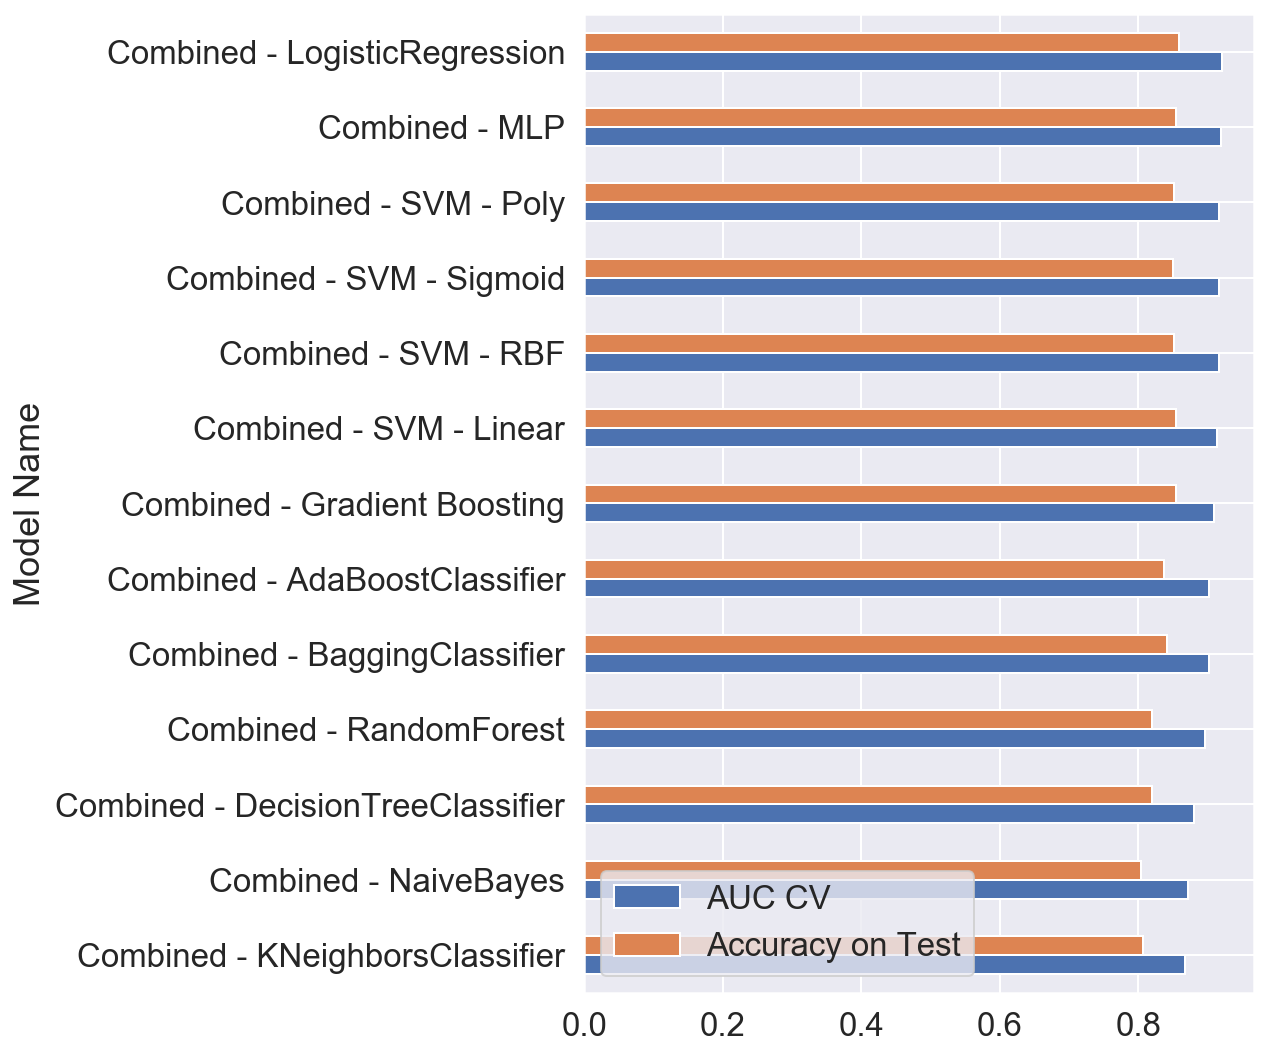

In [41]:
fig, ax = plt.subplots(figsize = (6,9));
resultsDF.set_index('Model Name')[['AUC CV','Accuracy on Test']].sort_values(
                                    by = 'AUC CV', ascending = True).plot(kind = 'barh', ax = ax);
ax.legend(loc = 'lower left');